In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo

In [3]:
train = pd.read_json("train.json")
test = pd.read_json("test.json")
# test.describe()

In [4]:
train.head()

,id,cuisine,ingredients
0,22675,italian,"[1% low-fat cottage cheese, low-fat marinara s..."
1,32288,southern_us,"[brown sugar, salt, eggs, butter, chopped peca..."
2,44406,thai,"[red chili peppers, bell pepper, garlic, fish ..."
3,29355,moroccan,"[water, green tea leaves, tangerine, fresh min..."
4,39350,chinese,"[vegetable oil, chile sauce, tomato paste, gar..."


In [5]:
# onehot encoder for ingredients
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
expandedLabelData_train = mlb.fit_transform(train["ingredients"])
labelClasses = mlb.classes_
expandedLabelData_test = mlb.fit_transform(test["ingredients"])
labelClasses_2 = mlb.classes_

expandedLabels_train = pd.DataFrame(expandedLabelData_train, columns=labelClasses)
expandedLabels_test = pd.DataFrame(expandedLabelData_test, columns=labelClasses_2)

In [6]:
# shuffle data
def shuffle(df_origin): 
    df = df_origin.sample(frac=1,random_state=113)#,random_state=113
    df2= df.reset_index(drop=True)
    return df2

df = pd.DataFrame(train.cuisine)
df = pd.concat([df,expandedLabels_train], axis = 1)
df_shuffle_train = shuffle(df)
print(df_shuffle_train)

df_shuffle_test = shuffle(expandedLabels_test)
print(df_shuffle_test)


        cuisine  (    oz.) tomato sauce  (   oz.) tomato paste  \
0       italian                       0                      0   
1         greek                       0                      0   
2        korean                       0                      0   
3       mexican                       0                      0   
4        indian                       0                      0   
...         ...                     ...                    ...   
29769    french                       0                      0   
29770  japanese                       0                      0   
29771   italian                       0                      0   
29772  japanese                       0                      0   
29773   italian                       0                      0   

       (10 oz.) frozen chopped spinach  \
0                                    0   
1                                    0   
2                                    0   
3                                    0 

In [7]:
#PCA for lower down dimensionality
from sklearn.decomposition import PCA
N_COMPONENTS = 512
pca = PCA(N_COMPONENTS)
pca.fit(df_shuffle_train[df_shuffle_train.columns[1:]])
df_shuffle_train_pca = pd.DataFrame(pca.transform(df_shuffle_train[df_shuffle_train.columns[1:]]))
df_shuffle_train_pca.head()
pca.fit(df_shuffle_test[df_shuffle_test.columns[1:]])
df_shuffle_test_pca = pd.DataFrame(pca.transform(df_shuffle_test[df_shuffle_test.columns[1:]]))

ValueError: operands could not be broadcast together with shapes (29774,6231) (4442,) 

In [ ]:
#transform cuisine
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df_shuffle_train.cuisine)
df_shuffle_train.cuisine = le.transform(df_shuffle_train.cuisine)
print(df_shuffle_train.cuisine)

In [ ]:
# train_test_split
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y = train_test_split(df_shuffle_train_pca, df_shuffle_train.cuisine, random_state=42, test_size=0.30)
print(len(train_x))
print()
print(len(test_x))

In [ ]:
# validation--> SVM
from sklearn.svm import SVC

svm_clf_lin = SVC(random_state=42,kernel='linear')
svm_clf_poly = SVC(random_state=42,kernel='poly')
svm_clf_rbf = SVC(random_state=42,kernel='rbf')
svm_clf_sigmoid = SVC(random_state=42,kernel='sigmoid')

svm_clf_lin = svm_clf_lin.fit(train_x,train_y)
svm_clf_poly = svm_clf_poly.fit(train_x,train_y)
svm_clf_rbf = svm_clf_rbf.fit(train_x,train_y)
svm_clf_sigmoid = svm_clf_sigmoid.fit(train_x,train_y)

In [ ]:
pred = []
pred.append(svm_clf_lin.predict(test_x))
pred.append(svm_clf_poly.predict(test_x))
pred.append(svm_clf_rbf.predict(test_x))
pred.append(svm_clf_sigmoid.predict(test_x))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

for i in range(len(pred)):
    print(i)
    fig, ax = plt.subplots(figsize=(15,15))
    ax = sns.heatmap(confusion_matrix(test_y, pred[i]),annot=True,cmap='coolwarm',fmt='d')
    print("recall: ", recall_score(test_y, pred[i], average='micro'))
    print("precision: ", precision_score(test_y, pred[i], average='macro'))
    print("accuracy: ", accuracy_score(test_y, pred[i]))
    print()
    plt.savefig(str(i))
    

In [ ]:
submit = le.inverse_transform(pred[2].to_list())
submit = pd.DataFrame(submit, columns = ['Id', 'Category'])
print(submit)
submit.to_csv("submission.csv")

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_x = train_x.astype("float32")
train_y = train_y.astype("float32")
test_x = test_x.astype("float32")
test_y = test_y.astype("float32")
# Reserve 8933 samples for validation
val_x = train_x[-8933:]
val_y = train_y[-8933:]
train_x = train_x[:-8933]
train_y = train_y[:-8933]

=============] - 2s 6ms/step - loss: 1.4556 - sparse_categorical_accuracy: 0.6007 - val_loss: 1.4991 - val_sparse_categorical_accuracy: 0.5800
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
Total params: 330,900
Trainable params: 330,900
Non-trainable params: 0
_________________________________________________________________
recall:  0.5793126609201836
precision:  0.5289977316897636
accuracy:  0.5793126609201836

Epoch 1/20
373/373 [==============================] - 2s 6ms/step - loss: 2.2879 - sparse_categorical_accuracy: 0.3802 - val_loss: 1.8421 - val_spa

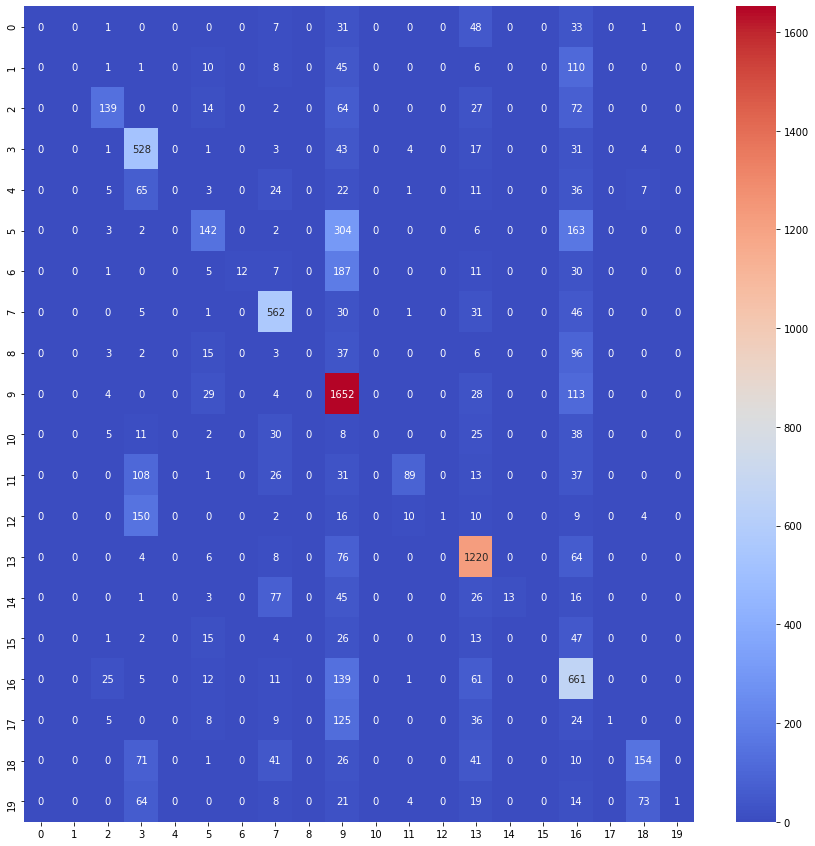

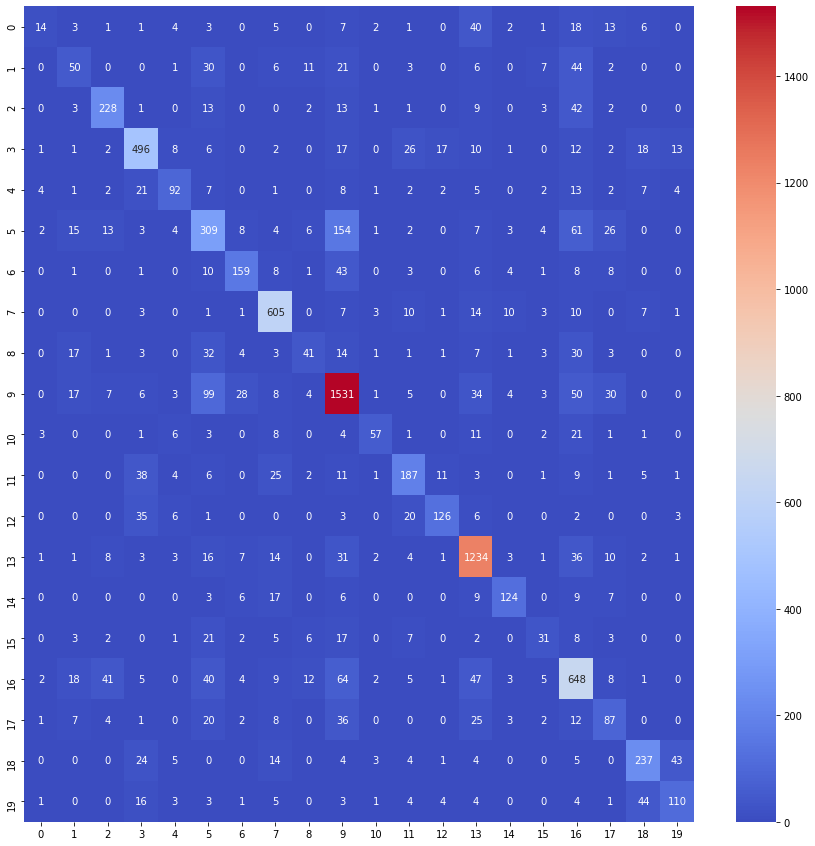

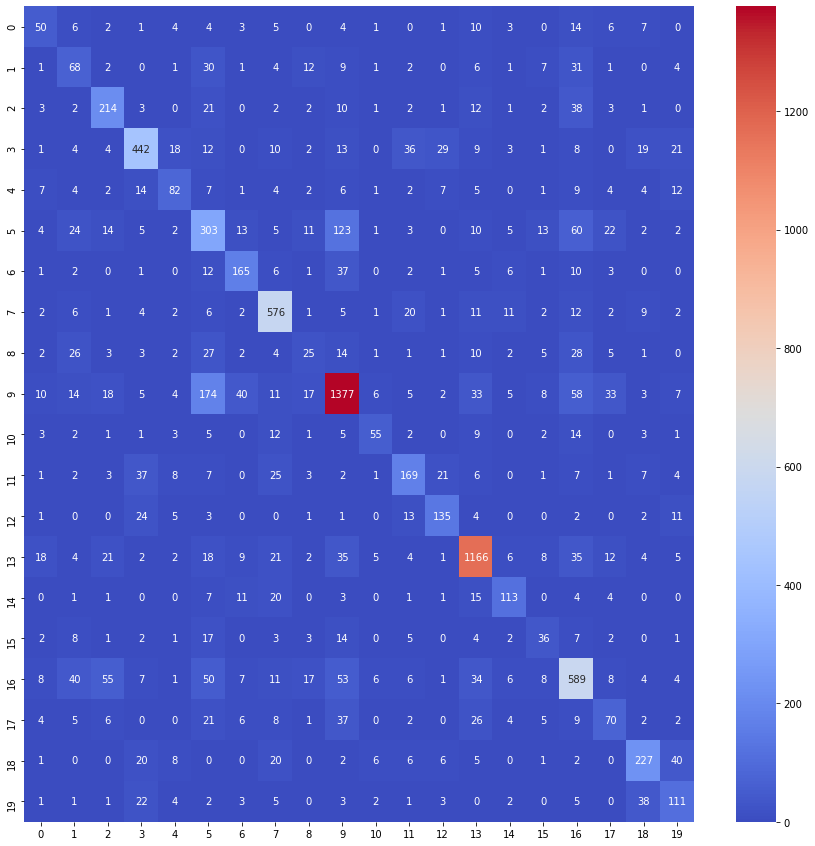

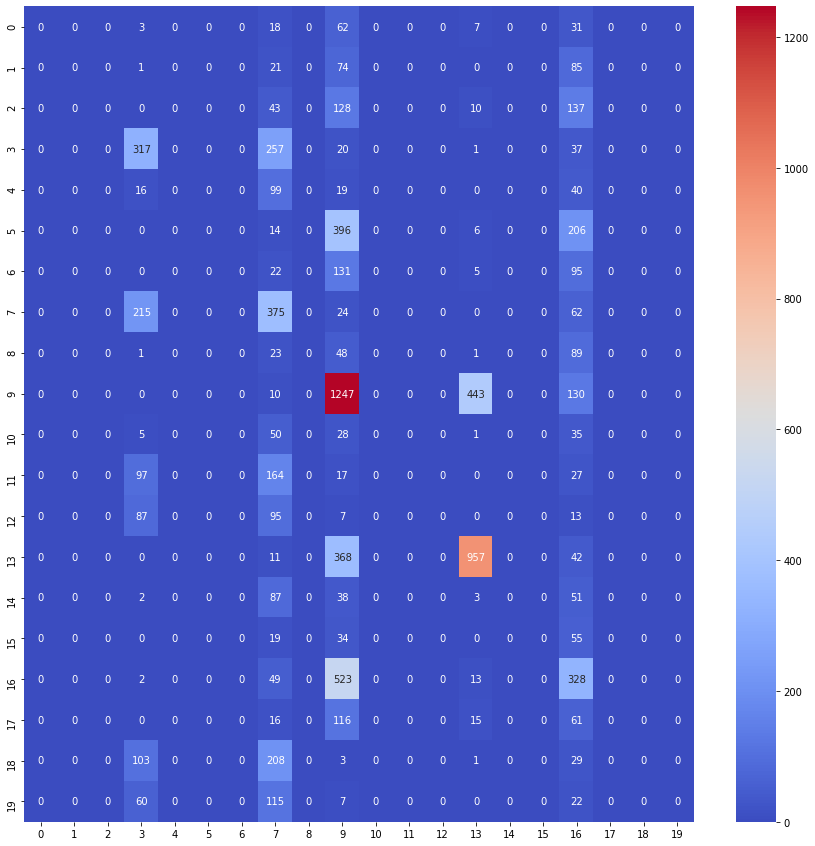

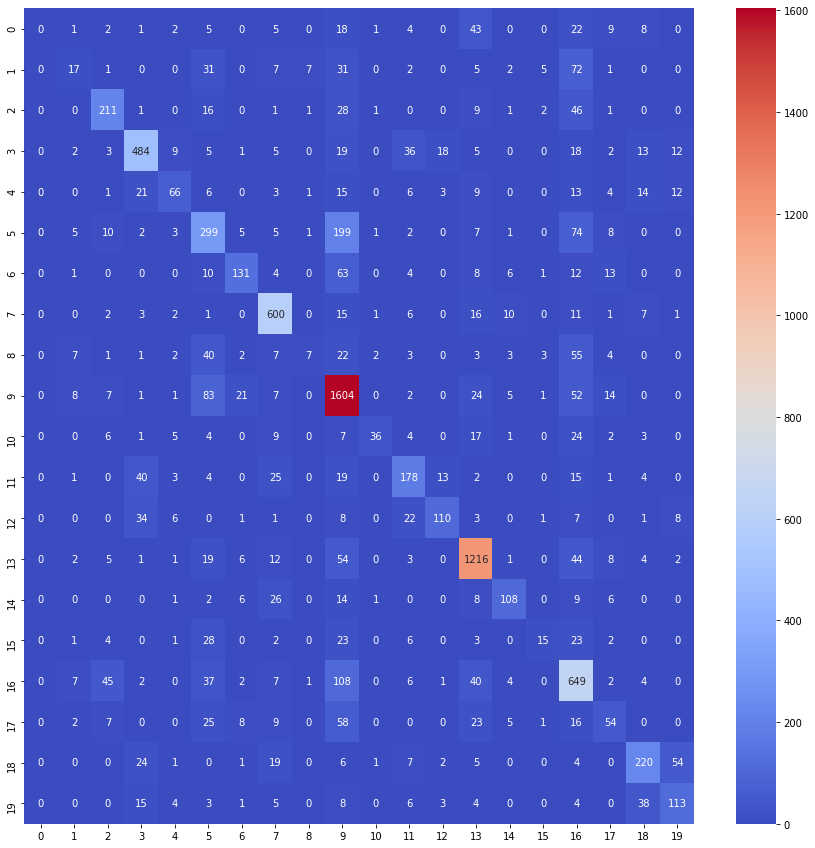

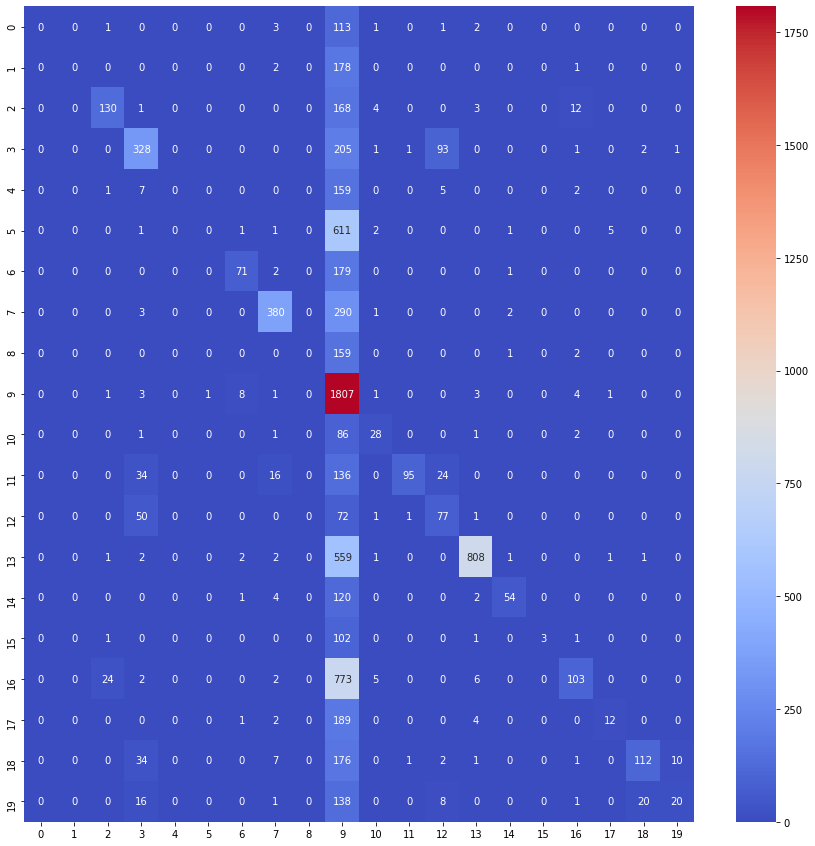

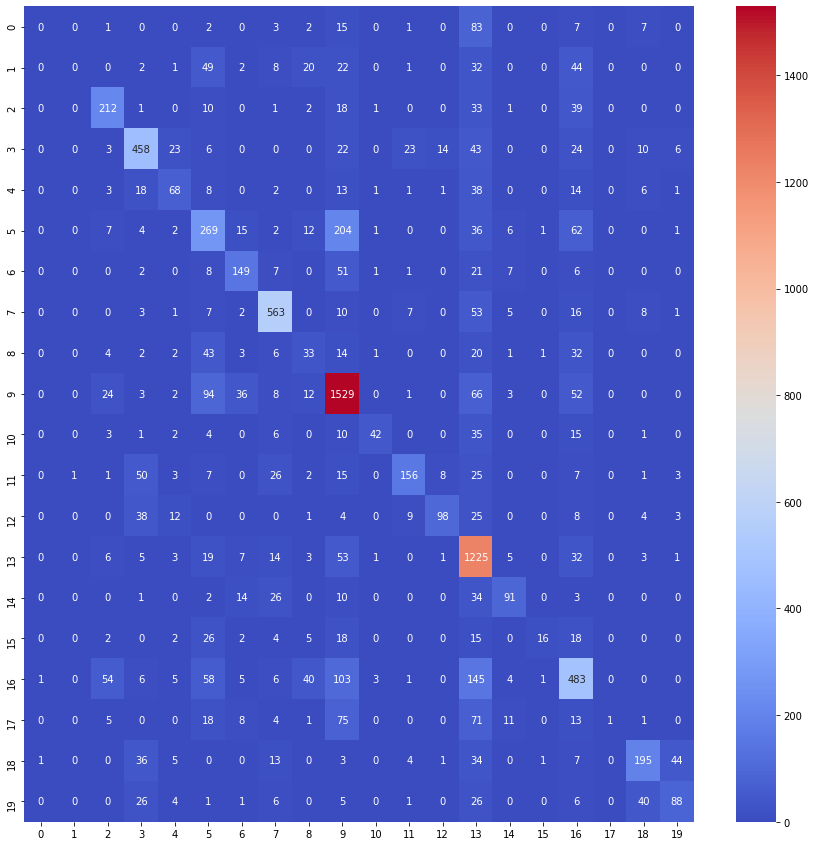

In [13]:
n = ["Adadelta","Adagrad", "Adam", "Ftrl", "SGD", "RMSprop", "Nadam"]
m = [tf.keras.optimizers.Adadelta(0.01), tf.keras.optimizers.Adagrad(0.01), tf.keras.optimizers.Adam(0.001), tf.keras.optimizers.Ftrl(0.01), tf.keras.optimizers.SGD(0.01), tf.keras.optimizers.RMSprop(0.01), tf.keras.optimizers.Nadam(0.01)]

for i in range(len(m)):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(20)
    ])

    model.compile(
        optimizer=m[i],
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    model.fit(
        train_x.values, train_y.values,
        epochs=20,
        validation_data=(val_x.values, val_y.values)
    )

    # model.summary()
    y = model.predict(test_x.values)
    pred = []
    for j in range(len(y)):
        pred.append(np.argmax(y[j]))
    # print(pred)

    fig, ax = plt.subplots(figsize=(15,15))
    ax = sns.heatmap(confusion_matrix(test_y, pred),annot=True,cmap='coolwarm',fmt='d')
    print(n[i])
    print("recall: ", recall_score(test_y, pred, average='micro'))
    print("precision: ", precision_score(test_y, pred, average='macro'))
    print("accuracy: ", accuracy_score(test_y, pred))
    print()
    plt.savefig('EMG {0}.jpg'.format(i)) 


In [ ]:
submit_nn = le.inverse_transform(pred[1].to_list())
print(submit_nn)
submit_nn.to_csv("submission_nn.csv")